In [8]:
# Metric Copy from implement by 
# https://www.kaggle.com/c/tensorflow-great-barrier-reef/discussion/290083
# https://www.kaggle.com/bamps53/competition-metric-implementation?scriptVersionId=81087805

# Yolo infer modified from 
# https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer

In [159]:
import glob
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 30, 30
np.set_printoptions(precision=3, suppress=True)
from ast import literal_eval

import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import sys
sys.path.append('../input/tensorflow-great-barrier-reef')
import torch
from PIL import Image
import ast

%matplotlib inline

In [55]:
def get_path(row):
    row['image_path'] = f'{ROOT_DIR}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def yolo2voc(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

def coco2yolo(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2coco(bboxes, image_height, image_width)
    return bboxes


def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, 
                bbox_format = 'yolo', class_name = False, line_thickness = 2):  
     
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]


def decode_annotations(annotaitons_str):
    """decode annotations in string to list of dict"""
    return literal_eval(annotaitons_str)

def load_image_with_annotations(video_id, video_frame, image_dir, annotaitons_str):
    img = load_image(video_id, video_frame, image_dir)
    annotations = decode_annotations(annotaitons_str)
    if len(annotations) > 0:
        for ann in annotations:
            cv2.rectangle(img, (ann['x'], ann['y']),
                (ann['x'] + ann['width'], ann['y'] + ann['height']),
                (255, 0, 0), thickness=2,)
    return img

def draw_predictions(img, pred_bboxes):
    img = img.copy()
    if len(pred_bboxes) > 0:
        for bbox in pred_bboxes:
            conf = bbox[0]
            x, y, w, h = bbox[1:].round().astype(int)
            cv2.rectangle(img, (x, y),
                (x+w, y+h),
                (0, 255, 255), thickness=2,)
            cv2.putText(
                img,
                f"{conf:.2}",
                (x, max(0, y-5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 255),
                thickness=1,
            )
    return img

In [180]:
def calc_iou(bboxes1, bboxes2, bbox_mode='xywh'):
    assert len(bboxes1.shape) == 2 and bboxes1.shape[1] == 4
    assert len(bboxes2.shape) == 2 and bboxes2.shape[1] == 4
    
    bboxes1 = bboxes1.copy()
    bboxes2 = bboxes2.copy()
    
    if bbox_mode == 'xywh':
        bboxes1[:, 2:] += bboxes1[:, :2]
        bboxes2[:, 2:] += bboxes2[:, :2]

    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

def f_beta(tp, fp, fn, beta=2):
    return (1+beta**2)*tp / ((1+beta**2)*tp + beta**2*(fn+fp))

def calc_is_correct_at_iou_th(gt_bboxes, pred_bboxes, iou_th, verbose=False):
    gt_bboxes = gt_bboxes.copy()
    pred_bboxes = pred_bboxes.copy()
    
    tp = 0
    fp = 0
    for pred_bbox in pred_bboxes:
        ious = calc_iou(gt_bboxes, pred_bbox[None, 1:])
        max_iou = ious.max()
        if max_iou > iou_th:
            tp += 1
            gt_bboxes = np.delete(gt_bboxes, ious.argmax(), axis=0)
        else:
            fp += 1
        if len(gt_bboxes) == 0:
            fp += len(pred_bboxes)
            break

    fn = len(gt_bboxes)
    return tp, fp, fn

def calc_is_correct(gt_bboxes, pred_bboxes):
    """
    gt_bboxes: (N, 4) np.array in xywh format
    pred_bboxes: (N, 5) np.array in conf+xywh format
    """
    if len(gt_bboxes) == 0 and len(pred_bboxes) == 0:
        tps, fps, fns = 0, 0, 0
        return tps, fps, fns
    
    elif len(gt_bboxes) == 0:
        tps, fps, fns = 0, len(pred_bboxes), 0
        return tps, fps, fns
    
    elif len(pred_bboxes) == 0:
        tps, fps, fns = 0, 0, len(gt_bboxes)
        return tps, fps, fns
    
    pred_bboxes = pred_bboxes[pred_bboxes[:,0].argsort()[::-1]] # sort by conf
    
    tps, fps, fns = 0, 0, 0
    for iou_th in np.arange(0.3, 0.85, 0.05):
        tp, fp, fn = calc_is_correct_at_iou_th(gt_bboxes, pred_bboxes, iou_th)
        tps += tp
        fps += fp
        fns += fn
    return tps, fps, fns

def calc_f2_score(gt_bboxes_list, pred_bboxes_list, verbose=False):
    """
    gt_bboxes_list: list of (N, 4) np.array in xywh format
    pred_bboxes_list: list of (N, 5) np.array in conf+xywh format
    """
    tps, fps, fns = 0, 0, 0
    for gt_bboxes, pred_bboxes in zip(gt_bboxes_list, pred_bboxes_list):
        tp, fp, fn = calc_is_correct(gt_bboxes, pred_bboxes)
        tps += tp
        fps += fp
        fns += fn
        if verbose:
            num_gt = len(gt_bboxes)
            num_pred = len(pred_bboxes)
            print(f'num_gt:{num_gt:<3} num_pred:{num_pred:<3} tp:{tp:<3} fp:{fp:<3} fn:{fn:<3}')
    print(f'tp:{tp}  fp:{fp}  fn:{fn}')
    return f_beta(tps, fps, fns, beta=2)

In [82]:
def load_model(ckpt_path, conf=0.25, iou=0.50):
    model = torch.hub.load('./',
                           'custom',
                           path=ckpt_path,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model


def predict(model, img_path, size=768, augment=False):
    img = load_image(img_path)
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)  # custom inference size
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        bboxes  = voc2coco(bboxes,height,width).astype(int)
        confs   = preds.confidence.values
        return bboxes, confs
    else:
        return [],[]
    
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

def show_img(img, bboxes, bbox_format='yolo'):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img).resize((800, 400))

In [69]:
DATA  = '../input/yolov5_fold0_nobbox003/train.csv'
CKPT_PATH = './starfish/yolov5x_20e_bs8_lr001_img1200_fold0_nobbox003/weights/best.pt'
IMG_SIZE  = 1280
CONF      = 0.15
IOU       = 0.50
MAX_DET   = 1000
AUGMENT   = False

In [208]:
model = torch.hub.load('../yolov5/',
                       'custom',
                       path="./starfish/yolov5x_20e_bs8_lr001_img1200_fold0_nobbox003/weights/best.pt",
                       source='local',
                       force_reload=True)

model.conf = CONF  # NMS confidence threshold
model.iou  = IOU  # NMS IoU threshold
model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
model.multi_label = False  # NMS multiple labels per box
model.max_det = MAX_DET  # maximum number of detections per image

YOLOv5 🚀 4fbb7c9 torch 1.9.1+cu111 CUDA:0 (NVIDIA GeForce RTX 3090, 24268MiB)

Fusing layers... 
Model Summary: 444 layers, 86173414 parameters, 0 gradients, 204.0 GFLOPs
Adding AutoShape... 


In [209]:
df = pd.read_csv(DATA)
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
val = df[df.fold == 'val'].reset_index(drop=True)
val['bboxes'] = val['bboxes'].apply(eval)

  0%|          | 0/5476 [00:00<?, ?it/s]

  0%|          | 0/5476 [00:00<?, ?it/s]

In [212]:
def evaluate(model, df, verbose=[0, 100, 200], **kw):
    verbose_cnt = 0
    gt_bbox_list = []
    pr_bboex_list = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        pred_bbox, pred_conf = predict(model, row.image_path, IMG_SIZE, AUGMENT)
        if len(pred_conf) > 0:
            pred = np.concatenate((pred_conf[..., None], pred_bbox), axis=1)
        else:
            pred = []
        gt = np.array(row.bboxes)
        gt_bbox_list.append(gt)
        pr_bboex_list.append(pred)
        if verbose_cnt in verbose:
            img = load_image(row.image_path)
            plt.figure(figsize=(16, 12))
            plt.imshow(show_img(img, pred_bbox, 'coco'))
        verbose_cnt += 1
#     return gt_bbox_list, pr_bboex_list
    score = calc_f2_score(gt_bbox_list, pr_bboex_list)
    print(f"F2 score {score: .5f}")
    return score

  0%|          | 0/971 [00:00<?, ?it/s]

KeyboardInterrupt: 

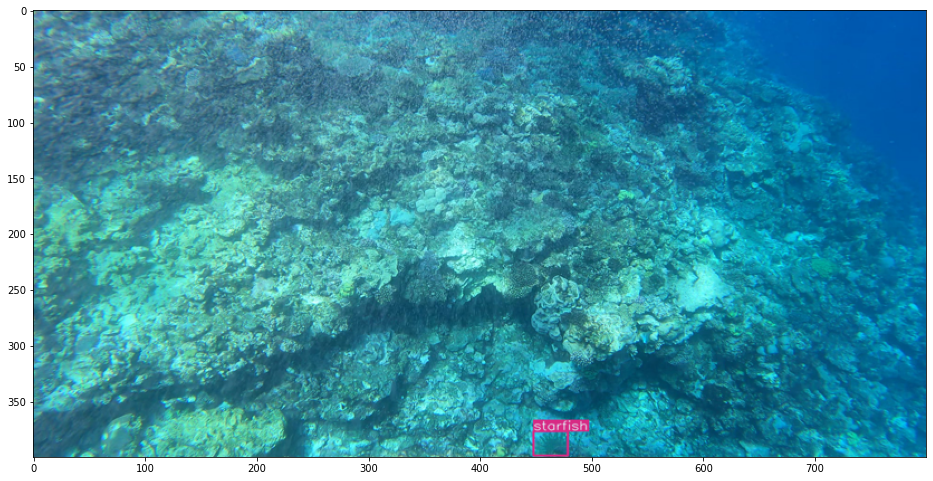

In [213]:
evaluate(model, val)